<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based sollely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you: 

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should: 

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

In [2]:
# Data manipulation and viz
import pandas as pd , numpy as np , re
import matplotlib.pyplot as plt , seaborn as sns , missingno as msno
#from wordcloud import WordCloud , STOPWORDS not available on python 3.11
from pytagcloud import create_tag_image, make_tags
from pytagcloud.lang.counter import get_tag_counts
from collections import Counter

# Modeling
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential , Model
from keras.layers import Dense , Embedding , Flatten , BatchNormalization , Input
import tensorflow as tf
from sklearn.metrics import f1_score , classification_report , accuracy_score , confusion_matrix, ConfusionMatrixDisplay
import transformers
from transformers import RobertaTokenizer , TFRobertaModel
from tensorflow import keras
#bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased") # Download BERT

# NLP and preprocessing
import re
from nltk.corpus import stopwords
from num2words import num2words
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

# Other
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)


pygame 2.3.0 (SDL 2.24.2, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the

## EDA

In [3]:
df = pd.read_csv('spam.csv' , header=None)
df.head()

,0,1,2,3,4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5572 non-null   object
 1   1       5572 non-null   object
 2   2       50 non-null     object
 3   3       12 non-null     object
 4   4       6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


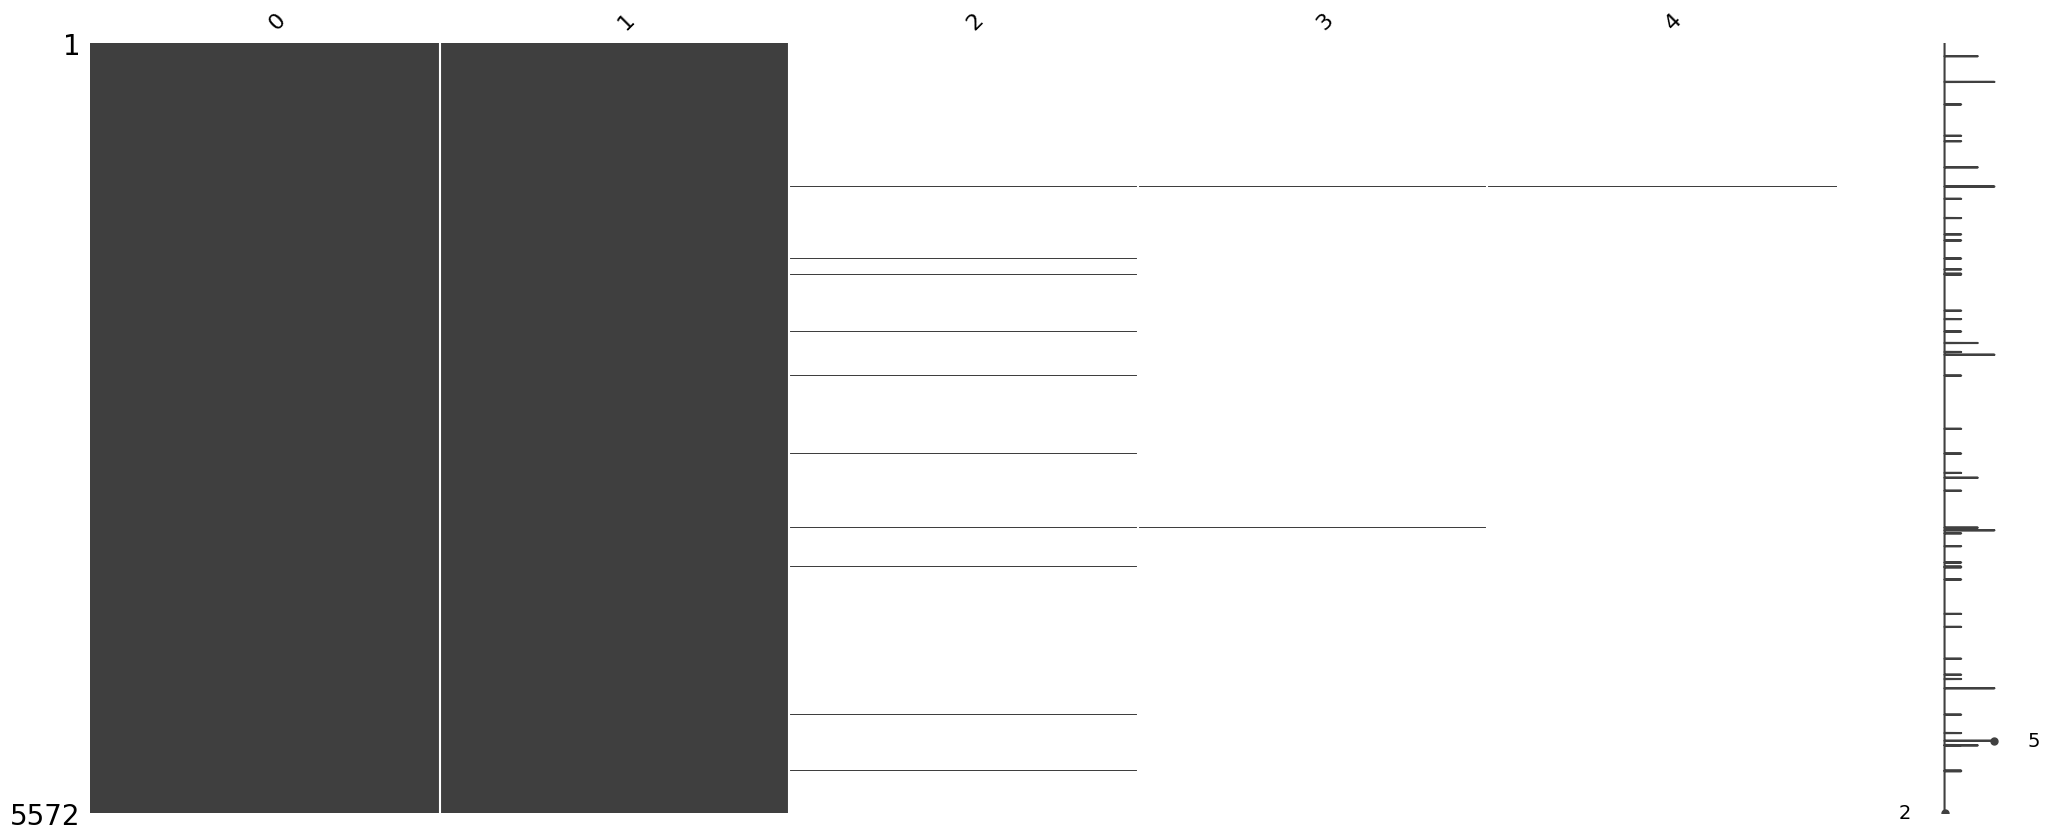

In [9]:
msno.matrix(df)
plt.show()

In [4]:
df = df.drop([2 , 3 , 4] , axis=1)
df.columns = ['is_spam' , 'message']
df['is_spam'] = [1 if mess == 'spam' else 0 for mess in df['is_spam']]
df = df[['message' , 'is_spam']]
df.head()

,message,is_spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


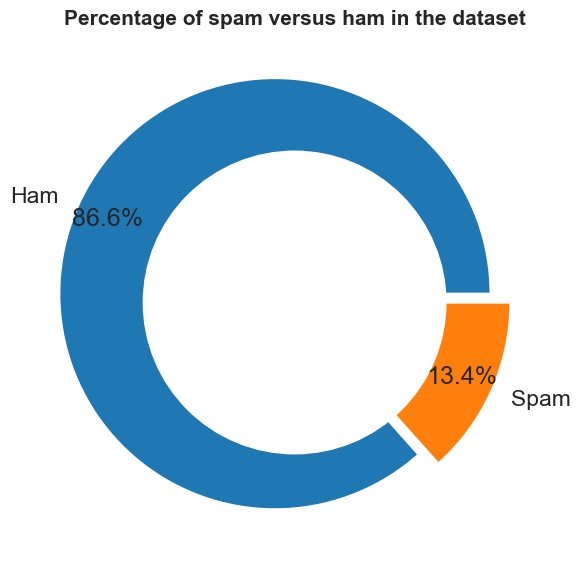

In [11]:
sns.set_style('darkgrid')
sns.set_context('talk')

plt.figure(figsize=(14,7))
vals = [len(df[df['is_spam'] == 0]) , len(df[df['is_spam'] == 1])]
labels = ['Ham' , 'Spam']

explode = (0.1, 0.001)
plt.pie(vals, labels=labels, autopct='%1.1f%%', pctdistance=0.85, explode=explode , shadow=False)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Percentage of spam versus ham in the dataset", fontsize=15, fontweight='bold')
plt.show()

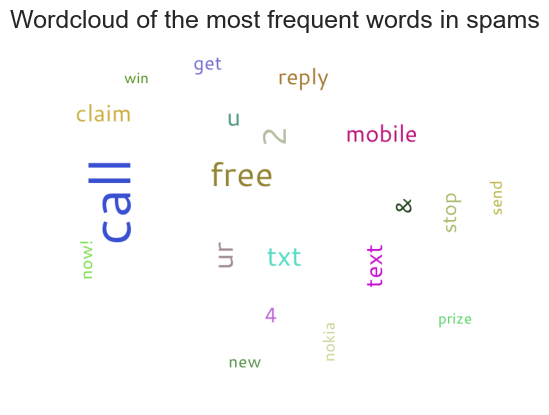

In [59]:
spams = ' '.join(list(df[df['is_spam'] == 1]['message'])).split()
spams = [word.lower() for word in spams]
spams = [word for word in spams if word not in set(stopwords.words('english'))]

word_counts = Counter(spams)


most_common_words = word_counts.most_common(20)
most_common_words


# Create a list of tags
tags = make_tags(dict(most_common_words).items(), maxsize=80)

# Générer le nuage de mots
create_tag_image(tags, "cloud.png", size=(800, 600), fontname="Cantarell")

# Afficher le nuage de mots
img = plt.imread("cloud.png")
plt.imshow(img)
plt.axis("off")
plt.title('Wordcloud of the most frequent words in spams')
plt.show()

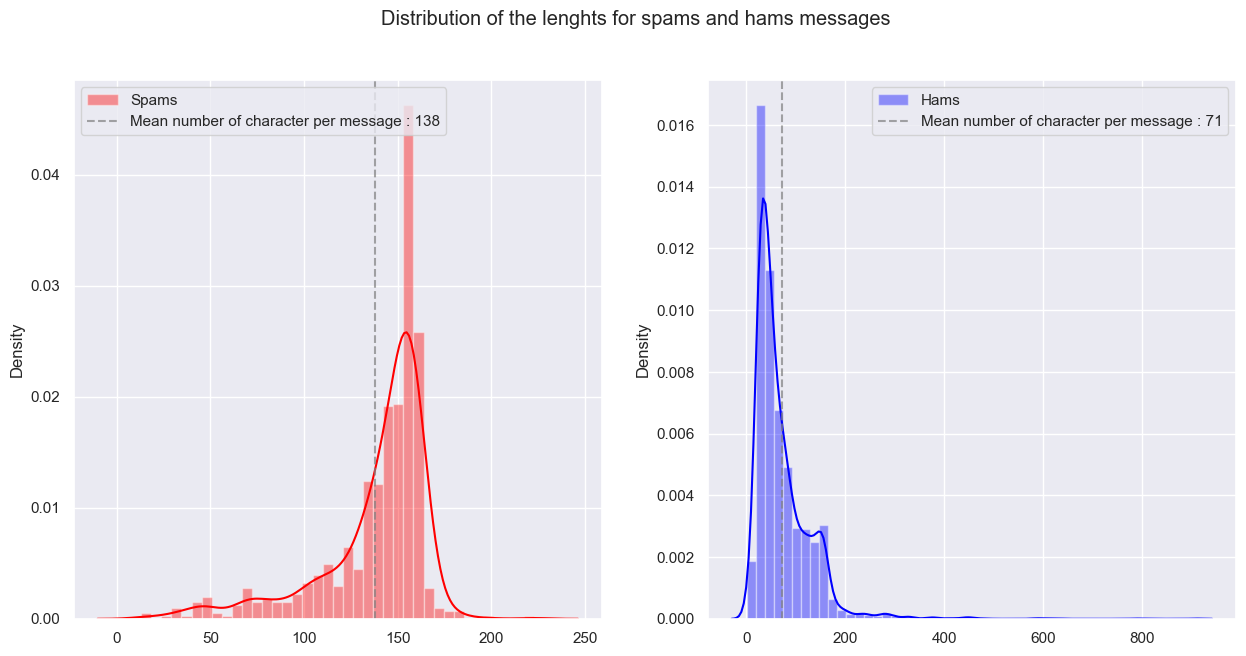

In [60]:
# Distribution of lens for spams versus hams
df['len'] = df['message'].apply(len)
spams_len = df[df['is_spam'] == 1]['len'].values
hams_len = df[df['is_spam'] == 0]['len'].values

mean_spams_len = round(np.mean(spams_len))
mean_hams_len = round(np.mean(hams_len))

with sns.plotting_context('notebook'):
    fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(15,7))
    sns.distplot(spams_len , ax=ax1 , label='Spams' , color='red')
    ax1.axvline(mean_spams_len , color='grey' , alpha=0.7 , linestyle='--' , label=f'Mean number of character per message : {mean_spams_len}')
    ax1.legend(loc='upper left')

    sns.distplot(hams_len , ax=ax2 , label='Hams' , color='blue')
    ax2.axvline(mean_hams_len , color='grey' , alpha=0.7 , linestyle='--' , label=f'Mean number of character per message : {mean_hams_len}')
    ax2.legend()

    fig.suptitle('Distribution of the lenghts for spams and hams messages')
    plt.show()

## Preprocessing

In [5]:
def clean_text(text : str):

    # Turn the number into features
    new_string = ''
    for word in text.split():
        try:
            new_string += num2words(word)
            new_string += ' '
        except:
            if len(word) > 2:
                new_string += word 
                new_string += ' '
                    
    text = new_string.strip() 

    # Remove special characters, punctuations and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

     # Lower case
    text = text.lower()
    

    # Stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    # Lemmatisasion
    lemmatizer = WordNetLemmatizer()

    # Return the clean text
    return  ' '.join(lemmatizer.lemmatize(word) for word in text.split())



def preprocess_for_deep_learning(column : str):

    # Create and fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(list(df[column]))

    # Convert to sequence of integers
    sequences = tokenizer.texts_to_sequences(df[column])

    # Padding to get the same lenghts
    max_len = max([len(seq) for seq in sequences])
    return tokenizer ,  pad_sequences(sequences, maxlen=max_len)

In [6]:
df['clean_message'] = df['message'].apply(clean_text)
tokenizer , vector_array = preprocess_for_deep_learning('clean_message')

vector_df = pd.DataFrame(vector_array , columns=[f'vect{i}' for i in range(vector_array.shape[1])])
vector_df['target'] = df['is_spam']

X = vector_df.drop('target' , axis=1)
y = vector_df['target']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.33 , stratify=y)
vector_df.head()

,vect0,vect1,vect2,vect3,vect4,vect5,vect6,vect7,vect8,vect9,...,vect67,vect68,vect69,vect70,vect71,vect72,vect73,vect74,vect75,target
0,0,0,0,0,0,0,0,0,0,0,...,523,1093,72,242,2449,1094,26,3518,78,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,252,1247,367,1604,0
2,0,0,0,0,0,0,0,0,0,0,...,5,253,356,282,772,33,229,106,299,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,165,68,287,2450,93,68,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,833,50,176,773,100,146,368,0


## Modeling

In [63]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.index_word) + 1, input_length=len(X_train.columns) , output_dim=16))
model.add(Flatten())
model.add(Dense(units=250, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=1 , activation='sigmoid'))
model.compile(optimizer='adam' , loss='binary_crossentropy' , metrics=['accuracy'])
model.fit(x=X_train , y=y_train , epochs=1000 , validation_data=(X_test , y_test))

Epoch 1/1000
117/117 [==============================] - 1s 5ms/step - loss: 0.2319 - accuracy: 0.9379 - val_loss: 0.2790 - val_accuracy: 0.8706
Epoch 2/1000
117/117 [==============================] - 1s 5ms/step - loss: 0.0390 - accuracy: 0.9906 - val_loss: 0.1771 - val_accuracy: 0.9206
Epoch 3/1000
117/117 [==============================] - 0s 4ms/step - loss: 0.0115 - accuracy: 0.9976 - val_loss: 0.0919 - val_accuracy: 0.9674
Epoch 4/1000
117/117 [==============================] - 0s 4ms/step - loss: 0.0093 - accuracy: 0.9995 - val_loss: 0.0654 - val_accuracy: 0.9782
Epoch 5/1000
117/117 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0443 - val_accuracy: 0.9891
Epoch 6/1000
117/117 [==============================] - 0s 4ms/step - loss: 9.6705e-04 - accuracy: 1.0000 - val_loss: 0.0559 - val_accuracy: 0.9891
Epoch 7/1000
117/117 [==============================] - 0s 4ms/step - loss: 9.2963e-04 - accuracy: 0.9997 - val_loss: 0.0808 - val_a

## Analysis of the results

58/58 [==============================] - 0s 1ms/step

Classification report : 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1592
           1       0.91      0.84      0.87       247

    accuracy                           0.97      1839
   macro avg       0.94      0.91      0.93      1839
weighted avg       0.97      0.97      0.97      1839
 

F1 score :  0.873 

Accuracy score :  0.967 



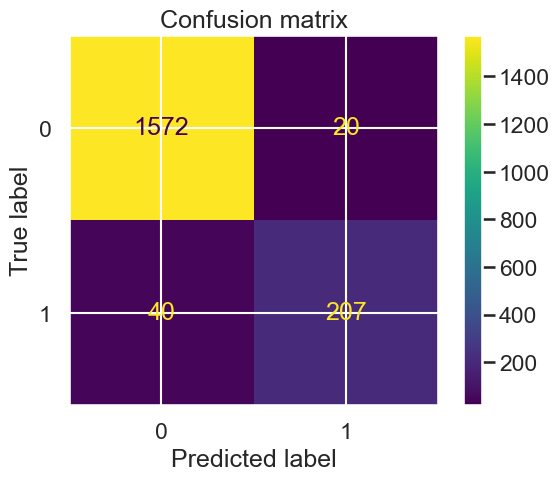

In [64]:
preds = list(model.predict(X_test).reshape(1,-1)[0])
preds = [int(pred) for pred in preds]
print('\nClassification report : \n')
print(classification_report(y_test , preds) , '\n')
print('F1 score : ' , round(f1_score(y_test , preds),3) , '\n')
print('Accuracy score : ' , round(accuracy_score(y_test , preds) , 3) , '\n')
cm_test = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm_test).plot()
plt.title('Confusion matrix')
plt.show()